In [46]:
# Install required packages for this notebook (run if packages missing).
# You can comment out lines if running in an environment where packages are preinstalled.
# Tweak: try different versions or omit installs if not needed by your environment.
!pip install -q numpy pandas matplotlib seaborn joblib scikit-learn xgboost scipy ipywidgets
# If running on a restricted environment, install only what you need, e.g.:
# !pip install -q pandas xgboost


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


# Cafe Success Prediction — Step-by-step Notebook

This notebook walks through data loading, EDA, feature engineering, baseline and XGBoost models, evaluation, and a sample prediction for a newly opening cafe. Each major step is a separate cell and produces visible outputs (tables or plots). The `success_score` column will be used only to create the binary `success_label` and will NOT be used as a model input.

In [47]:
# 0) Setup: imports and path detection
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import joblib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import xgboost as xgb

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# detect likely input CSV in repo (final folder under backend/Data/CSV)
candidates = [
    # Path('../Data/CSV_Reference/final/cafe_final.csv'),
    Path('../Data/CSV_Reference/final/master_cafe_path_minimal.csv'),
    Path('..') / 'Data' / 'CSV_Reference' / 'final' / 'master_cafe_path_minimal.csv',
]
DATA_CSV = next((p for p in candidates if p.exists()), None)
print('Detected data path:', DATA_CSV)
if DATA_CSV is None:
    raise FileNotFoundError('No input CSV found in ../Data/CSV_Reference/final — please run the generator first.')

# read CSV header to detect dynamic POI radius and column groups
csv_columns = pd.read_csv(DATA_CSV, nrows=0).columns.tolist()
print('Detected CSV columns:', len(csv_columns))

poi_pattern = re.compile(r'^(?P<category>.+)_(?P<kind>count|weight)_(?P<dist>\d+(?:\.\d+)?)_km$')
poi_matches = [poi_pattern.match(c) for c in csv_columns if poi_pattern.match(c)]
poi_distances = [m.group('dist') for m in poi_matches]
if not poi_distances:
    raise ValueError('No *_count_<dist>_km or *_weight_<dist>_km columns found in CSV header.')

from collections import Counter
dist_counts = Counter(poi_distances)
POI_RADIUS_KM = dist_counts.most_common(1)[0][0]
if len(dist_counts) > 1:
    print('Multiple POI radius values found:', dict(dist_counts), '| using:', POI_RADIUS_KM)
else:
    print('POI radius detected:', POI_RADIUS_KM, 'km')

POI_COUNT_COLS = [c for c in csv_columns if c.endswith(f'_count_{POI_RADIUS_KM}_km')]
POI_WEIGHT_COLS = [c for c in csv_columns if c.endswith(f'_weight_{POI_RADIUS_KM}_km')]
POI_CATEGORIES = sorted({poi_pattern.match(c).group('category') for c in POI_COUNT_COLS if poi_pattern.match(c)})
BASE_POI_CATEGORIES = [c for c in POI_CATEGORIES if c not in ('cafe', 'cafes')]
CAFE_WEIGHT_COL = 'cafe_weight' if 'cafe_weight' in csv_columns else None

def poi_col(category, kind):
    return f'{category}_{kind}_{POI_RADIUS_KM}_km'

print('POI categories:', POI_CATEGORIES)
print('Base POI categories (excluding cafes):', BASE_POI_CATEGORIES)
print('POI count columns:', POI_COUNT_COLS[:8], '...')
print('POI weight columns:', POI_WEIGHT_COLS[:8], '...')

Detected data path: ../Data/CSV_Reference/final/master_cafe_path_minimal.csv
Detected CSV columns: 18
POI radius detected: 0.3 km
POI categories: ['banks', 'cafes', 'education', 'health', 'other', 'temples']
Base POI categories (excluding cafes): ['banks', 'education', 'health', 'other', 'temples']
POI count columns: ['cafes_count_0.3_km', 'banks_count_0.3_km', 'education_count_0.3_km', 'health_count_0.3_km', 'other_count_0.3_km', 'temples_count_0.3_km'] ...
POI weight columns: ['cafes_weight_0.3_km', 'banks_weight_0.3_km', 'education_weight_0.3_km', 'health_weight_0.3_km', 'other_weight_0.3_km', 'temples_weight_0.3_km'] ...


## 1) Data loading and initial inspection
Load the CSV into a DataFrame and show head(), shape, and info().

In [48]:
df = pd.read_csv(DATA_CSV)
print('shape:', df.shape)
display(df.head(10))
print('Columns and dtypes:')
display(df.dtypes)
print('Info:')
df.info()

shape: (1330, 18)


,name,lat,lng,category,cafes_count_0.3_km,cafes_weight_0.3_km,banks_count_0.3_km,banks_weight_0.3_km,education_count_0.3_km,education_weight_0.3_km,health_count_0.3_km,health_weight_0.3_km,other_count_0.3_km,other_weight_0.3_km,temples_count_0.3_km,temples_weight_0.3_km,cafe_weight,poi_composite_score
0,.....,27.673504,85.385463,Fast food restaurant,34,0.379126,11,0.512634,0,0.000000,4,0.368690,6,0.432085,19,0.192875,0.718427,2.315768
1,1-shika café and Chat house,27.681387,85.376168,Coffee shop,9,0.301663,1,0.245530,0,0.000000,0,0.000000,5,0.237859,0,0.000000,0.550539,1.568197
2,12 Shutter,27.696212,85.376926,Restaurant,21,0.282030,0,0.000000,0,0.000000,0,0.000000,5,0.129454,4,0.057023,0.794790,1.272025
3,"12sutar chok,Deepa",27.697660,85.377711,Coffee shop,15,0.116079,1,0.144011,0,0.000000,0,0.000000,6,0.145409,2,0.139757,0.500000,0.958110
4,"1990s laphing,dhara",27.671898,85.438394,Restaurant,16,0.290798,5,0.306294,9,0.230100,18,0.217208,1,0.058277,24,0.159590,0.500000,2.378709
5,3 R khaja ghar,27.674177,85.394862,Fast food restaurant,9,0.119607,1,0.000098,1,0.098594,0,0.000000,0,0.000000,0,0.000000,0.660206,1.928324
6,3rd eyes fast food,27.666652,85.427026,Restaurant,43,0.230672,14,0.203598,26,0.228314,25,0.181528,6,0.134803,9,0.213703,0.601078,2.986771
7,5I Restaurant,27.684457,85.410917,Family restaurant,14,0.371474,1,0.224090,1,0.041754,2,0.364563,2,0.398858,0,0.000000,0.692421,1.121943
8,6/9 Khaja Ghar,27.678406,85.386372,Fast food restaurant,25,0.242945,1,0.047694,0,0.000000,1,0.160294,4,0.122269,56,0.193362,0.500000,2.039182
9,90's Cafe,27.674219,85.389935,Coffee shop,10,0.156604,3,0.078696,0,0.000000,0,0.000000,3,0.349132,1,0.120343,0.737557,2.099121


Columns and dtypes:


name                           str
lat                        float64
lng                        float64
category                       str
cafes_count_0.3_km           int64
cafes_weight_0.3_km        float64
banks_count_0.3_km           int64
banks_weight_0.3_km        float64
education_count_0.3_km       int64
education_weight_0.3_km    float64
health_count_0.3_km          int64
health_weight_0.3_km       float64
other_count_0.3_km           int64
other_weight_0.3_km        float64
temples_count_0.3_km         int64
temples_weight_0.3_km      float64
cafe_weight                float64
poi_composite_score        float64
dtype: object

Info:
<class 'pandas.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     1330 non-null   str    
 1   lat                      1330 non-null   float64
 2   lng                      1330 non-null   float64
 3   category                 1330 non-null   str    
 4   cafes_count_0.3_km       1330 non-null   int64  
 5   cafes_weight_0.3_km      1330 non-null   float64
 6   banks_count_0.3_km       1330 non-null   int64  
 7   banks_weight_0.3_km      1330 non-null   float64
 8   education_count_0.3_km   1330 non-null   int64  
 9   education_weight_0.3_km  1330 non-null   float64
 10  health_count_0.3_km      1330 non-null   int64  
 11  health_weight_0.3_km     1330 non-null   float64
 12  other_count_0.3_km       1330 non-null   int64  
 13  other_weight_0.3_km      1330 non-null   float64
 14  temples_count_0.3_km     1330

## 2) Missing value analysis
Display missing value counts and a bar plot for missing percentages.

In [49]:
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df) * 100).round(2)
missing_tbl = pd.DataFrame({'count': missing_counts, 'pct': missing_pct})
display(missing_tbl.head(30))
# bar plot of top missing columns (limit to 30)
top = missing_tbl[missing_tbl['count']>0].head(30)
if not top.empty:
    plt.figure(figsize=(10,6))
    sns.barplot(x=top['pct'], y=top.index, orient='h', palette='viridis')
    plt.xlabel('Percent missing')
    plt.title('Top columns by percent missing')
    plt.tight_layout()
    plt.show()
else:
    print('No missing values detected.')

,count,pct
name,0,0.0
lat,0,0.0
lng,0,0.0
category,0,0.0
cafes_count_0.3_km,0,0.0
cafes_weight_0.3_km,0,0.0
banks_count_0.3_km,0,0.0
banks_weight_0.3_km,0,0.0
education_count_0.3_km,0,0.0
education_weight_0.3_km,0,0.0


No missing values detected.


## 3) Target variable creation
Create `success_label` as a binary target using the median of `success_score`. Visualize the distribution and class balance.

Using score column (REGRESSION TARGET): poi_composite_score
Score range: 0.536 to 3.767
Mean score: 1.817, Std: 0.786


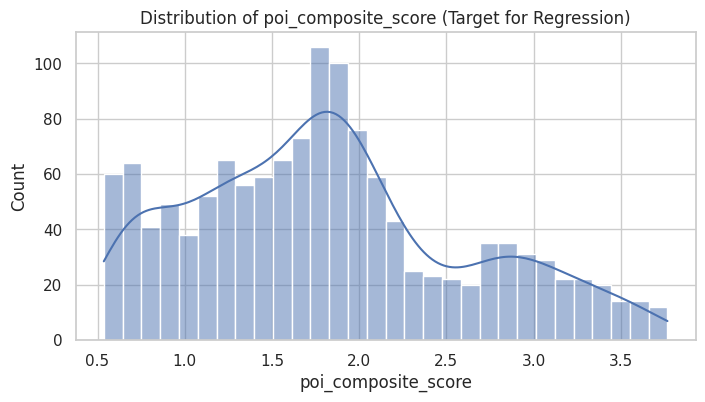


Target Variable Statistics:
count    1330.000000
mean        1.817276
std         0.785931
min         0.536008
25%         1.217240
50%         1.769123
75%         2.223650
max         3.767343
Name: poi_composite_score, dtype: float64


In [50]:
# detect and use poi_composite_score as target directly (no binary conversion)
score_col = next((c for c in df.columns if c.lower().strip() == 'poi_composite_score'), None)
if score_col is None:
    # broaden search to likely score-like columns
    candidates_score = [c for c in df.columns if any(k in c.lower() for k in ['composite','score','metric','target'])]
    # prefer ones containing 'composite' or 'score' first
    score_col = next((c for c in candidates_score if 'composite' in c.lower() or 'score' in c.lower()), None)
    if score_col is None and candidates_score:
        score_col = candidates_score[0]
if score_col is None:
    raise KeyError(f'Could not find a `poi_composite_score`-like column. Available columns: {list(df.columns)}.\nPlease provide a CSV with a `poi_composite_score` column.')
print('Using score column (REGRESSION TARGET):', score_col)
# drop rows missing the score (we cannot predict those)
df = df.dropna(subset=[score_col]).reset_index(drop=True)

# Use the continuous score directly as target (no binarization)
y_continuous = df[score_col].copy()
print(f'Score range: {y_continuous.min():.3f} to {y_continuous.max():.3f}')
print(f'Mean score: {y_continuous.mean():.3f}, Std: {y_continuous.std():.3f}')

# distribution plot
plt.figure(figsize=(8,4))
sns.histplot(df[score_col], bins=30, kde=True)
plt.title('Distribution of ' + score_col + ' (Target for Regression)')
plt.show()

# Show basic statistics
print(f'\nTarget Variable Statistics:')
print(df[score_col].describe())

## 4) Exploratory data analysis (EDA)
Plot distributions of a few key numeric features (ratings, review counts, nearby cafes). Column names are detected heuristically; placeholders are used if not present.

Detected columns: rating= None reviews= None nearby= None
No rating column found for plotting
No reviews column found for plotting
No nearby-cafe column found for plotting


<Figure size 1200x400 with 0 Axes>

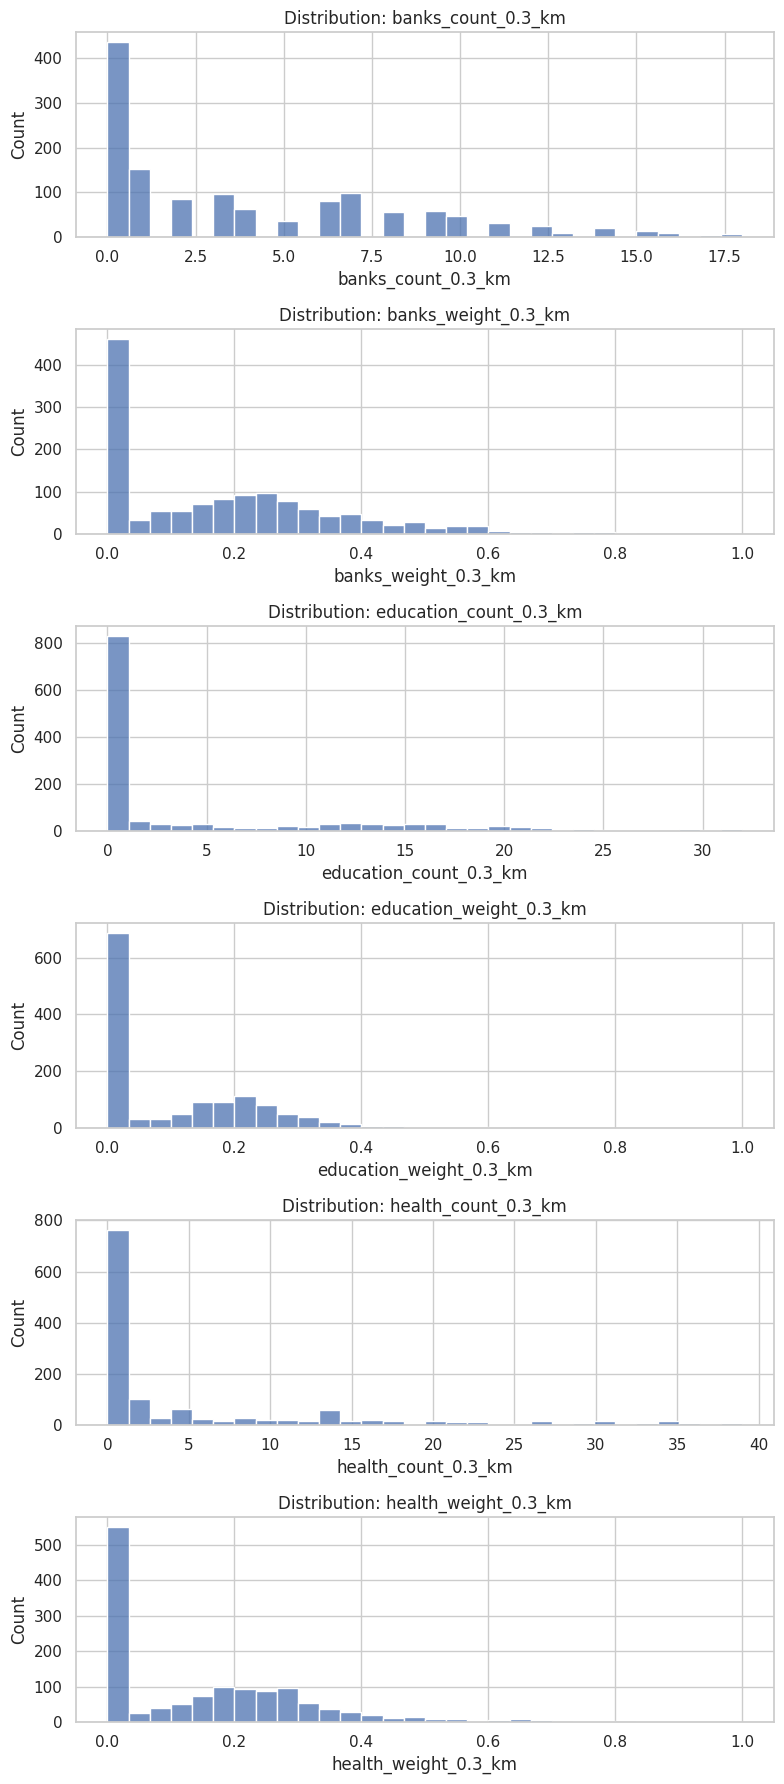

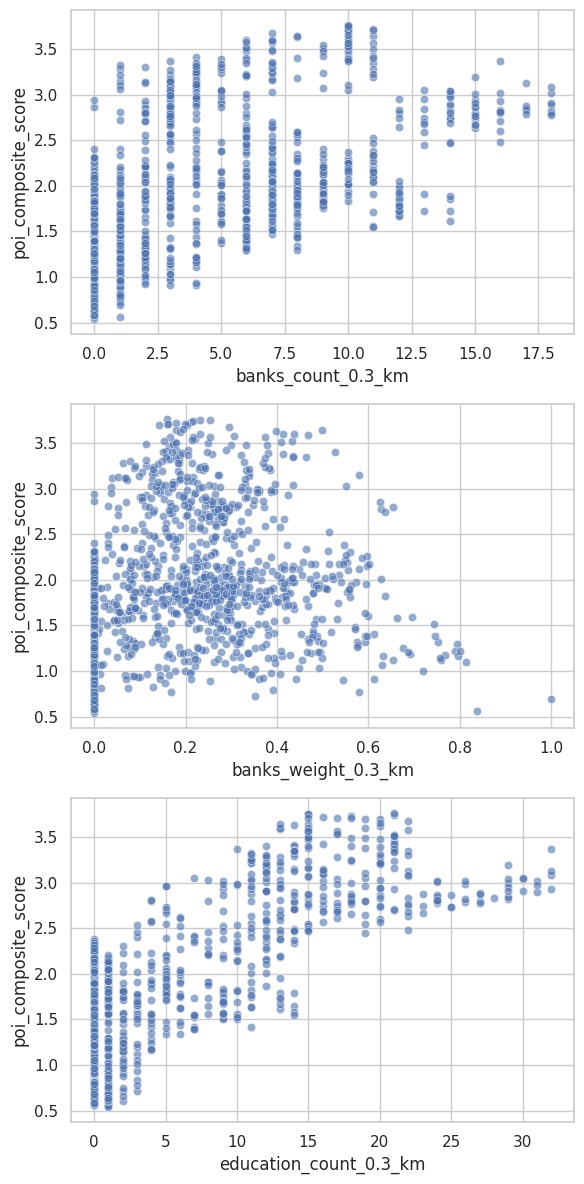

In [51]:
# helper to detect common column names
def detect_col(cands):
    cols = set(df.columns)
    for c in cands:
        if c in cols:
            return c
    return None

rating_col = detect_col(['rating','rating_avg','stars'])
reviews_col = detect_col(['review_count','reviews','reviews_count','reviewscount'])
nearby_col = detect_col(['nearby_cafe_count','nearby_cafes','nearby_cafes_count','cafe_nearby_count','nearby'])
print('Detected columns: rating=', rating_col, 'reviews=', reviews_col, 'nearby=', nearby_col)
# plot any that exist
plt.figure(figsize=(12,4))
plotted = False
if rating_col is not None:
    plt.subplot(1,3,1)
    sns.histplot(df[rating_col].dropna(), bins=20)
    plt.title('Rating distribution')
    plotted = True
else:
    print('No rating column found for plotting')
if reviews_col is not None:
    plt.subplot(1,3,2)
    sns.histplot(np.log1p(df[reviews_col].fillna(0)), bins=20)
    plt.title('Log(1+reviews) distribution')
    plotted = True
else:
    print('No reviews column found for plotting')
if nearby_col is not None:
    plt.subplot(1,3,3)
    sns.histplot(df[nearby_col].fillna(0), bins=20)
    plt.title('Nearby cafe count distribution')
    plotted = True
else:
    print('No nearby-cafe column found for plotting')
if plotted:
    plt.tight_layout()
    plt.show()

# If nothing (or limited) plotted, also show distributions for POI count/weight components
if not plotted:
    comp_cands = []
    for cat in BASE_POI_CATEGORIES:
        count_col = poi_col(cat, 'count')
        weight_col = poi_col(cat, 'weight')
        if count_col in df.columns:
            comp_cands.append(count_col)
        if weight_col in df.columns:
            comp_cands.append(weight_col)
    if CAFE_WEIGHT_COL in df.columns:
        comp_cands.append(CAFE_WEIGHT_COL)
    if comp_cands:
        n = min(len(comp_cands), 6)
        plt.figure(figsize=(8,3*n))
        for i,c in enumerate(comp_cands[:n]):
            plt.subplot(n,1,i+1)
            sns.histplot(df[c].dropna(), bins=30)
            plt.title(f'Distribution: {c}')
        plt.tight_layout()
        plt.show()
        # if score available and numeric, scatter top 3 components vs score
        if 'poi_composite_score' in df.columns and pd.api.types.is_numeric_dtype(df['poi_composite_score']):
            top_scatter = comp_cands[:3]
            plt.figure(figsize=(6,4*len(top_scatter)))
            for i,c in enumerate(top_scatter):
                plt.subplot(len(top_scatter),1,i+1)
                sns.scatterplot(x=df[c], y=df['poi_composite_score'], alpha=0.6)
                plt.xlabel(c)
                plt.ylabel('poi_composite_score')
            plt.tight_layout()
            plt.show()
    else:
        print('No POI component columns available for additional EDA')

## 5) Feature engineering
Create features: . Show a preview and plot a correlation heatmap with the target.

In [52]:
# Feature engineering — create meaningful ratio and aggregation features
eng = pd.DataFrame(index=df.index)

print('Creating engineered features from POI count and weight columns...\n')
print('=' * 70)

# Small epsilon to prevent division by zero
EPSILON = 1e-6

# Build dynamic POI column lists based on detected radius
count_cols = [poi_col(cat, 'count') for cat in BASE_POI_CATEGORIES if poi_col(cat, 'count') in df.columns]
weight_cols = [poi_col(cat, 'weight') for cat in BASE_POI_CATEGORIES if poi_col(cat, 'weight') in df.columns]

if not count_cols:
    raise KeyError('No POI count columns found for feature engineering. Check CSV header and POI radius detection.')

# ============================================================================
# 1. Total POI Count (within detected radius)
# ============================================================================
eng['total_poi_count_km'] = df[count_cols].fillna(0).sum(axis=1)
print('✓ total_poi_count_km: Sum of all POI counts for detected radius')

# ============================================================================
# 2. Category Ratios (proportion of each POI type)
# ============================================================================
for cat in BASE_POI_CATEGORIES:
    col = poi_col(cat, 'count')
    if col in df.columns:
        ratio_col = f'{cat}_ratio'
        eng[ratio_col] = df[col].fillna(0) / (eng['total_poi_count_km'] + EPSILON)
        print(f'✓ {ratio_col}: {col} / total_poi_count_km')

# ============================================================================
# 3. Weighted POI Strength (quality-adjusted total POI influence)
# ============================================================================
if weight_cols:
    eng['weighted_POI_strength'] = df[weight_cols].fillna(0).sum(axis=1)
    print('✓ weighted_POI_strength: Sum of all POI weights (quality-adjusted activity level)')
else:
    eng['weighted_POI_strength'] = 0.0
    print('✓ weighted_POI_strength: No weight columns found; defaulting to 0.0')

print('=' * 70)
print(f'\nSuccessfully engineered {len(eng.columns)} new features!\n')

# ============================================================================
# Merge engineered features with original dataset
# ============================================================================
df_merged = pd.concat([df.reset_index(drop=True), eng.reset_index(drop=True)], axis=1)

# Expose engineered feature list for later cells
ENGINEERED_FEATURES = eng.columns.tolist()

# ============================================================================
# Display: Preview of engineered features
# ============================================================================
print('Preview of newly engineered features (first 10 rows):')
print('=' * 70)
display(eng.head(10))

# ============================================================================
# Display: Summary statistics
# ============================================================================
print('\n' + '=' * 70)
print('Summary Statistics for Engineered Features:')
print('=' * 70)
display(eng.describe())

# ============================================================================
# Additional info: Feature ranges
# ============================================================================
print('\n' + '=' * 70)
print('Feature Ranges:')
print('=' * 70)
for col in eng.columns:
    min_val = eng[col].min()
    max_val = eng[col].max()
    mean_val = eng[col].mean()
    print(f'{col:30s}: min={min_val:10.4f}, max={max_val:10.4f}, mean={mean_val:10.4f}')
print('=' * 70)


Creating engineered features from POI count and weight columns...

✓ total_poi_count_km: Sum of all POI counts for detected radius
✓ banks_ratio: banks_count_0.3_km / total_poi_count_km
✓ education_ratio: education_count_0.3_km / total_poi_count_km
✓ health_ratio: health_count_0.3_km / total_poi_count_km
✓ other_ratio: other_count_0.3_km / total_poi_count_km
✓ temples_ratio: temples_count_0.3_km / total_poi_count_km
✓ weighted_POI_strength: Sum of all POI weights (quality-adjusted activity level)

Successfully engineered 7 new features!

Preview of newly engineered features (first 10 rows):


,total_poi_count_km,banks_ratio,education_ratio,health_ratio,other_ratio,temples_ratio,weighted_POI_strength
0,40,0.275000,0.000000,0.100000,0.150000,0.475000,1.506284
1,6,0.166667,0.000000,0.000000,0.833333,0.000000,0.483389
2,9,0.000000,0.000000,0.000000,0.555555,0.444444,0.186477
3,9,0.111111,0.000000,0.000000,0.666667,0.222222,0.429177
4,57,0.087719,0.157895,0.315789,0.017544,0.421053,0.971469
5,2,0.500000,0.500000,0.000000,0.000000,0.000000,0.098692
6,80,0.175000,0.325000,0.312500,0.075000,0.112500,0.961946
7,6,0.166667,0.166667,0.333333,0.333333,0.000000,1.029265
8,62,0.016129,0.000000,0.016129,0.064516,0.903226,0.523619
9,7,0.428571,0.000000,0.000000,0.428571,0.142857,0.548171



Summary Statistics for Engineered Features:


,total_poi_count_km,banks_ratio,education_ratio,health_ratio,other_ratio,temples_ratio,weighted_POI_strength
count,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000
mean,30.882707,0.163291,0.125258,0.126242,0.233865,0.330291,0.874636
std,36.937909,0.195177,0.174750,0.157299,0.219086,0.272823,0.462021
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.092427,0.116430,0.547681
50%,15.000000,0.089331,0.000000,0.062500,0.166667,0.250000,0.901881
75%,45.000000,0.250000,0.223659,0.204412,0.312500,0.516673,1.170461
max,153.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.608624



Feature Ranges:
total_poi_count_km            : min=    0.0000, max=  153.0000, mean=   30.8827
banks_ratio                   : min=    0.0000, max=    1.0000, mean=    0.1633
education_ratio               : min=    0.0000, max=    1.0000, mean=    0.1253
health_ratio                  : min=    0.0000, max=    1.0000, mean=    0.1262
other_ratio                   : min=    0.0000, max=    1.0000, mean=    0.2339
temples_ratio                 : min=    0.0000, max=    1.0000, mean=    0.3303
weighted_POI_strength         : min=    0.0000, max=    4.6086, mean=    0.8746


## 6) Drop identifier and leakage-prone columns
Identify and drop ID-like or leakage columns (we will list what we drop). Do NOT drop `success_score` until after label creation above.

In [53]:
# Identify and drop leakage/identifier columns, but KEEP our engineered features

# Define our NEW engineered features that should NEVER be dropped
try:
    ENGINEERED_FEATURES = ENGINEERED_FEATURES
except NameError:
    ENGINEERED_FEATURES = []

print('✓ Protected engineered features (will NOT be dropped):')
for feat in ENGINEERED_FEATURES:
    if feat in df_merged.columns:
        print(f'  - {feat}')
print()

# Identify identifier columns
possible_ids = [c for c in df_merged.columns if any(k in c.lower() for k in ['id','name','place','address','url','link','title'])]

# Identify raw data columns that should be dropped (not our engineered features!)
leak_keywords = ['success','raw_score','composite']
leak_cols = [c for c in df_merged.columns if c != score_col and any(k in c.lower() for k in leak_keywords)]

# Add raw POI columns (but NOT our engineered features)
raw_poi_cols = []
for c in POI_COUNT_COLS + POI_WEIGHT_COLS:
    if c in df_merged.columns and c not in ENGINEERED_FEATURES:
        raw_poi_cols.append(c)
if CAFE_WEIGHT_COL in df_merged.columns and CAFE_WEIGHT_COL not in ENGINEERED_FEATURES:
    raw_poi_cols.append(CAFE_WEIGHT_COL)

# Always mark textual identifiers
for c in ['title','name','place_id','placeid','id']:
    if c in df_merged.columns and c not in leak_cols:
        possible_ids.append(c)

# Union all drop candidates, but EXCLUDE our engineered features
drop_candidates = list(dict.fromkeys([c for c in (possible_ids + leak_cols + raw_poi_cols) 
                                      if c in df_merged.columns 
                                      and c not in ENGINEERED_FEATURES]))

# Build reasons for each candidate
reasons = {}
for c in drop_candidates:
    low = c.lower()
    parts = []
    if any(k in low for k in ['id','place_id','placeid','place','address','url','link','name','title']):
        parts.append('Identifier')
    if any(k in low for k in ['score','success','raw_score','target','composite']):
        parts.append('Target/score')
    if c in POI_COUNT_COLS or c in POI_WEIGHT_COLS:
        parts.append('Raw POI data (replaced by engineered features)')
    if c == CAFE_WEIGHT_COL:
        parts.append('Raw data (used in feature engineering)')
    if not parts:
        parts.append('Suspected leakage')
    reasons[c] = ', '.join(parts)

# Create report
import pandas as _pd
_pd.set_option('display.max_colwidth', None)
report_rows = []
for c in drop_candidates:
    sample_vals = df_merged[c].dropna().unique()[:5].tolist() if c in df_merged.columns else []
    report_rows.append({'column': c, 'dtype': str(df_merged[c].dtype) if c in df_merged.columns else 'NA', 'example_values': sample_vals, 'reason': reasons[c]})
drop_report = _pd.DataFrame(report_rows)

print('Columns identified for dropping and why (drop will happen next):')
display(drop_report)

# Compute final drop list (excluding score and label)
drop_list = [c for c in drop_candidates if c not in [score_col, 'success_label']]

print(f'\n✓ Keeping {len(ENGINEERED_FEATURES)} engineered features')
print(f'✓ Dropping {len(drop_list)} raw/leakage columns')
print('\nPlanned drop columns (will be removed in next cell):')
print(drop_list[:50])

# Keep reference for later use
dropped_columns = drop_list

# Display planned drops with reasons
display(_pd.DataFrame({'planned_drop': dropped_columns, 'reason': [reasons.get(c, '') for c in dropped_columns]}))


✓ Protected engineered features (will NOT be dropped):
  - total_poi_count_km
  - banks_ratio
  - education_ratio
  - health_ratio
  - other_ratio
  - temples_ratio
  - weighted_POI_strength

Columns identified for dropping and why (drop will happen next):


,column,dtype,example_values,reason
0,name,str,"[....., 1-shika café and Chat house, 12 Shutter, 12sutar chok,Deepa, 1990s laphing,dhara]",Identifier
1,cafes_count_0.3_km,int64,"[34, 9, 21, 15, 16]",Raw POI data (replaced by engineered features)
2,banks_count_0.3_km,int64,"[11, 1, 0, 5, 14]",Raw POI data (replaced by engineered features)
3,education_count_0.3_km,int64,"[0, 9, 1, 26, 20]",Raw POI data (replaced by engineered features)
4,health_count_0.3_km,int64,"[4, 0, 18, 25, 2]",Raw POI data (replaced by engineered features)
5,other_count_0.3_km,int64,"[6, 5, 1, 0, 2]",Raw POI data (replaced by engineered features)
6,temples_count_0.3_km,int64,"[19, 0, 4, 2, 24]",Raw POI data (replaced by engineered features)
7,cafes_weight_0.3_km,float64,"[0.379126, 0.301663, 0.28203, 0.116079, 0.290798]",Raw POI data (replaced by engineered features)
8,banks_weight_0.3_km,float64,"[0.512634, 0.24553, 0.0, 0.144011, 0.306294]",Raw POI data (replaced by engineered features)
9,education_weight_0.3_km,float64,"[0.0, 0.2301, 0.098594, 0.228314, 0.041754]",Raw POI data (replaced by engineered features)



✓ Keeping 7 engineered features
✓ Dropping 14 raw/leakage columns

Planned drop columns (will be removed in next cell):
['name', 'cafes_count_0.3_km', 'banks_count_0.3_km', 'education_count_0.3_km', 'health_count_0.3_km', 'other_count_0.3_km', 'temples_count_0.3_km', 'cafes_weight_0.3_km', 'banks_weight_0.3_km', 'education_weight_0.3_km', 'health_weight_0.3_km', 'other_weight_0.3_km', 'temples_weight_0.3_km', 'cafe_weight']


,planned_drop,reason
0,name,Identifier
1,cafes_count_0.3_km,Raw POI data (replaced by engineered features)
2,banks_count_0.3_km,Raw POI data (replaced by engineered features)
3,education_count_0.3_km,Raw POI data (replaced by engineered features)
4,health_count_0.3_km,Raw POI data (replaced by engineered features)
5,other_count_0.3_km,Raw POI data (replaced by engineered features)
6,temples_count_0.3_km,Raw POI data (replaced by engineered features)
7,cafes_weight_0.3_km,Raw POI data (replaced by engineered features)
8,banks_weight_0.3_km,Raw POI data (replaced by engineered features)
9,education_weight_0.3_km,Raw POI data (replaced by engineered features)


## 6) Drop identifier and leakage-prone columns
Identify and drop ID-like or leakage columns (we will list what we drop). Do NOT drop `success_score` until after label creation above.

In [54]:
# (This cell performs the actual drop of planned leakage columns after feature engineering and identification)
# Use the previously computed `drop_list` (planned drops from the report cell). If not found, build an empty list.
try:
    planned = drop_list
except NameError:
    planned = []
# ensure we never drop the score or label
planned = [c for c in planned if c not in [score_col, 'success_label']]
print('Dropping the following columns now:', planned)
# perform drop on the merged dataframe (df_merged created in feature engineering cell)
df_dropped = df_merged.drop(columns=planned, errors='ignore').copy()
# update dropped_columns and Xf for downstream steps
dropped_columns = planned
Xf = df_dropped.copy()
print('Shape after dropping:', df_dropped.shape)
# show dropped columns as a table for verification
import pandas as _pd
display(_pd.DataFrame({'dropped_columns': dropped_columns, 'reason': [reasons.get(c, '') for c in dropped_columns]}))

Dropping the following columns now: ['name', 'cafes_count_0.3_km', 'banks_count_0.3_km', 'education_count_0.3_km', 'health_count_0.3_km', 'other_count_0.3_km', 'temples_count_0.3_km', 'cafes_weight_0.3_km', 'banks_weight_0.3_km', 'education_weight_0.3_km', 'health_weight_0.3_km', 'other_weight_0.3_km', 'temples_weight_0.3_km', 'cafe_weight']
Shape after dropping: (1330, 11)


,dropped_columns,reason
0,name,Identifier
1,cafes_count_0.3_km,Raw POI data (replaced by engineered features)
2,banks_count_0.3_km,Raw POI data (replaced by engineered features)
3,education_count_0.3_km,Raw POI data (replaced by engineered features)
4,health_count_0.3_km,Raw POI data (replaced by engineered features)
5,other_count_0.3_km,Raw POI data (replaced by engineered features)
6,temples_count_0.3_km,Raw POI data (replaced by engineered features)
7,cafes_weight_0.3_km,Raw POI data (replaced by engineered features)
8,banks_weight_0.3_km,Raw POI data (replaced by engineered features)
9,education_weight_0.3_km,Raw POI data (replaced by engineered features)


In [55]:
# Build model features using the API endpoints (POIs + road accessibility).
# Requires the backend running at http://127.0.0.1:8000
import json
from urllib.parse import urlencode
from urllib.request import Request, urlopen
from pathlib import Path

API_BASE = "http://127.0.0.1:8000/api/v1"
USE_API_FEATURES = True
API_CACHE_PATH = Path("api_feature_cache.csv")
API_TIMEOUT_S = 30

def fetch_model_input(lat, lng, radius_km=None, decay_scale_km=None, include_network=True, include_road_metrics=True, road_radius_km=None):
    params = {
        "lat": float(lat),
        "lon": float(lng),
        "include_network": str(include_network).lower(),
        "include_road_metrics": str(include_road_metrics).lower(),
    }
    if radius_km is not None:
        params["radius_km"] = float(radius_km)
    if decay_scale_km is not None:
        params["decay_scale_km"] = float(decay_scale_km)
    if road_radius_km is not None:
        params["road_radius_km"] = float(road_radius_km)
    url = f"{API_BASE}/model-input/?" + urlencode(params)
    req = Request(url, headers={"Accept": "application/json"})
    with urlopen(req, timeout=API_TIMEOUT_S) as resp:
        data = json.loads(resp.read().decode("utf-8"))
    return data.get("feature_vector") or {}

if USE_API_FEATURES:
    if API_CACHE_PATH.exists():
        X_api = pd.read_csv(API_CACHE_PATH)
        if "_row_index" in X_api.columns:
            X_api = X_api.set_index("_row_index").sort_index()
        X_api = X_api.reindex(df.index)
        print("Loaded cached API features:", X_api.shape)
    else:
        rows = []
        for idx, row in df.iterrows():
            if idx % 100 == 0:
                print(f"API features: processed {idx} / {len(df)}")
            try:
                features = fetch_model_input(
                    row["lat"],
                    row["lng"],
                    radius_km=float(POI_RADIUS_KM),
                    decay_scale_km=float(POI_RADIUS_KM),
                    include_network=True,
                    include_road_metrics=True,
                    road_radius_km=float(POI_RADIUS_KM),
                )
            except Exception as exc:
                print(f"Warning: feature fetch failed at row {idx}: {exc}")
                features = {}
            features["_row_index"] = int(idx)
            rows.append(features)
        X_api = pd.DataFrame(rows).set_index("_row_index").sort_index()
        X_api = X_api.reindex(df.index)
        cache_out = X_api.copy()
        cache_out["_row_index"] = cache_out.index
        cache_out.to_csv(API_CACHE_PATH, index=False)
        print("Saved API feature cache:", API_CACHE_PATH)
    print("API feature matrix shape:", X_api.shape)

Loaded cached API features: (1330, 3)
API feature matrix shape: (1330, 3)


## 7) Train–test split
Use a 70/30 split with `random_state=42` and show shapes and class distributions.

In [56]:
# prepare X, y: exclude the original score from features (use it only as target)
exclude = [score_col] + dropped_columns
X = Xf.drop(columns=[c for c in exclude if c in Xf.columns], errors='ignore').copy()
y = y_continuous.copy()  # Use the continuous score, not binary label

use_api_features = isinstance(globals().get("X_api"), pd.DataFrame) and not X_api.empty and USE_API_FEATURES
if use_api_features:
    X_num = X_api.select_dtypes(include=[np.number]).copy()
    print("Using API-derived feature matrix")
else:
    # select numeric features for baseline modeling
    X_num = X.select_dtypes(include=[np.number]).copy()
    print("Using CSV-derived feature matrix")

# simple median imputation for numeric features
X_num = X_num.fillna(X_num.median())
print('Feature matrix shape (numeric only):', X_num.shape)
print('Target variable (continuous poi_composite_score):', y.shape)
# 70/30 split — regression task with continuous target
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.3, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('\nTrain target statistics:')
display(y_train.describe())
print('\nTest target statistics:')
display(y_test.describe())

Using API-derived feature matrix
Feature matrix shape (numeric only): (1330, 3)
Target variable (continuous poi_composite_score): (1330,)
Train shape: (931, 3) Test shape: (399, 3)

Train target statistics:


count    931.000000
mean       1.835390
std        0.790283
min        0.536008
25%        1.228118
50%        1.798802
75%        2.273396
max        3.767343
Name: poi_composite_score, dtype: float64


Test target statistics:


count    399.000000
mean       1.775008
std        0.775020
min        0.563792
25%        1.203872
50%        1.684558
75%        2.098227
max        3.749230
Name: poi_composite_score, dtype: float64

##  Just the test set


In [57]:
# Add this cell after the train-test split cell

# Get the actual cafe data for test set
test_indices = X_test.index
test_cafes = df.loc[test_indices, ['name', 'lat', 'lng', 'category', score_col]].copy()

print(f'TEST SET: {len(test_cafes)} cafes (30% of data)')
print('='*70)
display(test_cafes.head(20))

# Save test set cafes to CSV for external testing
test_cafes.to_csv('../Data/CSV_Reference/final/test_set_cafes.csv', index=False)
print(f'\n✓ Test set saved to: ../Data/CSV_Reference/final/test_set_cafes.csv')

# Show geographical distribution
print('\nTest Set Geographic Range:')
print(f'Latitude:  {test_cafes["lat"].min():.6f} to {test_cafes["lat"].max():.6f}')
print(f'Longitude: {test_cafes["lng"].min():.6f} to {test_cafes["lng"].max():.6f}')

# Show category distribution in test set
print('\nTest Set by Category:')
display(test_cafes['category'].value_counts().head(10))

TEST SET: 399 cafes (30% of data)


,name,lat,lng,category,poi_composite_score
893,Ramchandra Chiya Pasal,27.670185,85.382267,Tea store,1.702552
115,Banglamukhi Dairy and Bakery,27.669582,85.372855,Coffee shop,1.809201
526,Jbs Bakery,27.674893,85.369622,Bakery,1.542608
175,Buddy's Cafe Gothatar,27.699977,85.367482,Fast food restaurant,1.082660
63,Amarsinghchowk Hotel,27.701555,85.385587,Coffee shop,0.845280
1134,The Biryani house,27.665449,85.391638,Family restaurant,1.443362
1091,Sweet Hopes,27.681280,85.397713,Cafe,1.709772
788,Newari Chulo and Restaurant,27.669335,85.388153,Restaurant,1.568587
286,Daju bhai dharane sekuva kuna,27.677553,85.397435,Restaurant,1.809932
339,Durbar Coffee & Eatery,27.672341,85.426608,Coffee shop,3.281671



✓ Test set saved to: ../Data/CSV_Reference/final/test_set_cafes.csv

Test Set Geographic Range:
Latitude:  27.631760 to 27.715765
Longitude: 85.364538 to 85.480695

Test Set by Category:


category
Restaurant              117
Coffee shop              57
Cafe                     46
Bakery                   41
Fast food restaurant     36
Family restaurant        18
Bar                      18
Asian restaurant          8
Tea store                 7
Nepalese restaurant       6
Name: count, dtype: int64

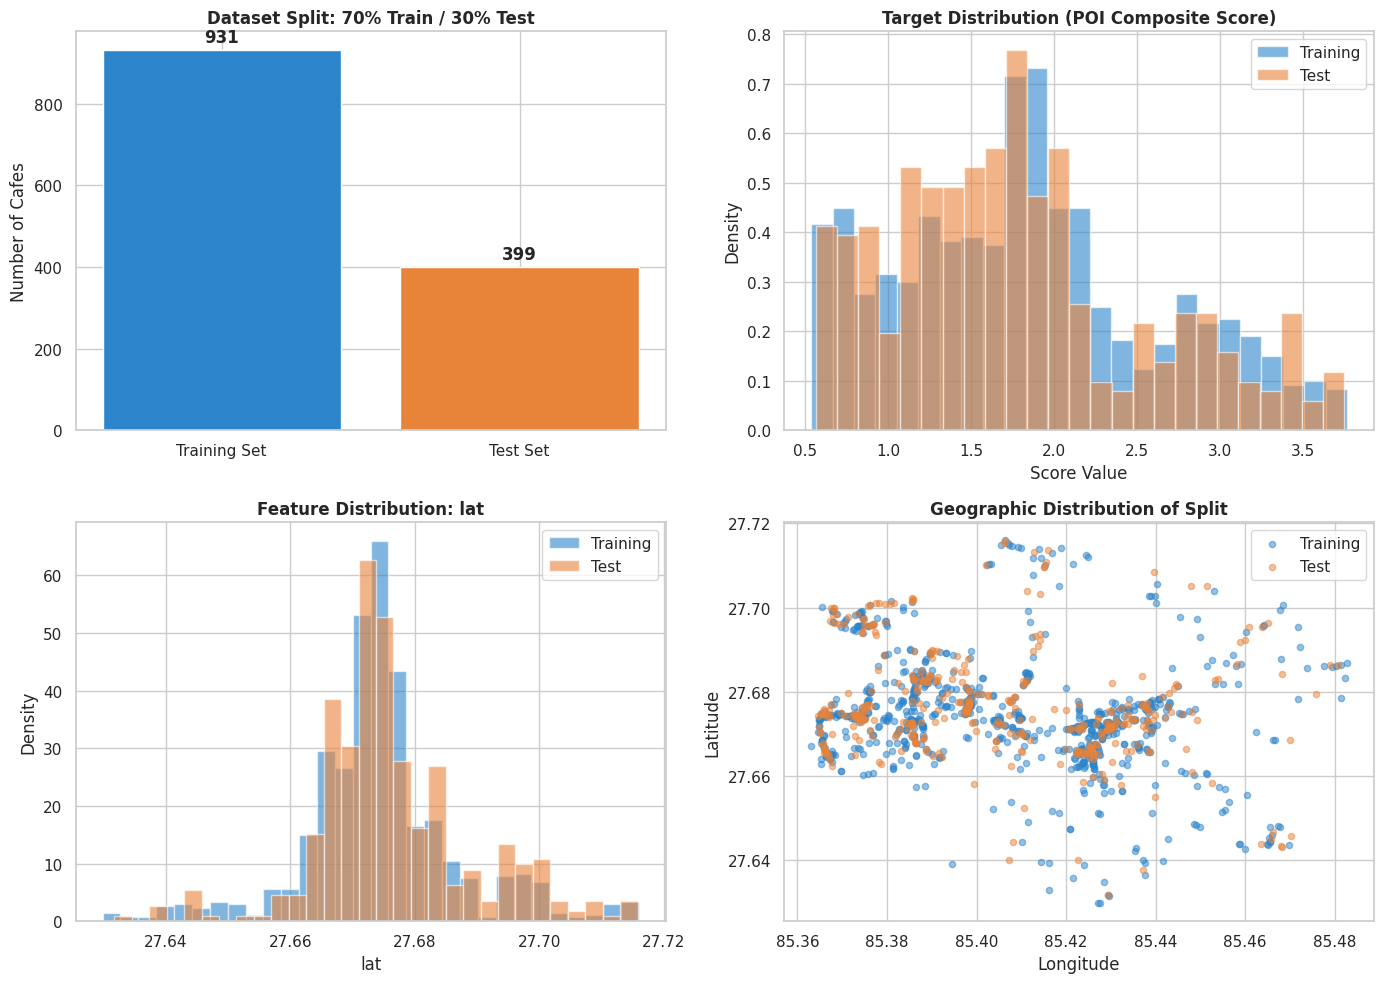


TRAIN-TEST SPLIT SUMMARY:
✓ Training set: 931 cafes (model learns from these)
✓ Test set: 399 cafes (model never sees these during training)
✓ Random seed 42: Same split every time you run the notebook

Target Variable Statistics:
  Train - Mean: 1.8354, Std: 0.7903, Range: [0.5360, 3.7673]
  Test  - Mean: 1.7750, Std: 0.7750, Range: [0.5638, 3.7492]


In [58]:
# Visualize the train-test split for regression task

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Train vs Test Size
axes[0, 0].bar(['Training Set', 'Test Set'], 
               [len(X_train), len(X_test)], 
               color=['#2C84CB', '#E8833A'])
axes[0, 0].set_title('Dataset Split: 70% Train / 30% Test', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Cafes')
for i, v in enumerate([len(X_train), len(X_test)]):
    axes[0, 0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# 2. Target Variable Distribution in Train vs Test
axes[0, 1].hist(y_train, bins=25, alpha=0.6, label='Training', color='#2C84CB', density=True)
axes[0, 1].hist(y_test, bins=25, alpha=0.6, label='Test', color='#E8833A', density=True)
axes[0, 1].set_title('Target Distribution (POI Composite Score)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Score Value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# 3. Feature Distribution: Example with first numeric feature
if len(X_train.columns) > 0:
    feature_col = X_train.columns[0]
    axes[1, 0].hist(X_train[feature_col], bins=30, alpha=0.6, 
                    label='Training', color='#2C84CB', density=True)
    axes[1, 0].hist(X_test[feature_col], bins=30, alpha=0.6, 
                    label='Test', color='#E8833A', density=True)
    axes[1, 0].set_title(f'Feature Distribution: {feature_col}', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel(feature_col)
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
else:
    axes[1, 0].text(0.5, 0.5, 'No features available', ha='center', va='center')

# 4. Geographic Distribution (if lat/lng available)
train_indices = X_train.index
if 'lat' in df.columns and 'lng' in df.columns:
    train_locs = df.loc[train_indices, ['lat', 'lng']]
    test_locs = df.loc[test_indices, ['lat', 'lng']]
    
    axes[1, 1].scatter(train_locs['lng'], train_locs['lat'], 
                      alpha=0.5, s=20, label='Training', color='#2C84CB')
    axes[1, 1].scatter(test_locs['lng'], test_locs['lat'], 
                      alpha=0.5, s=20, label='Test', color='#E8833A')
    axes[1, 1].set_title('Geographic Distribution of Split', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Longitude')
    axes[1, 1].set_ylabel('Latitude')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

print('\n' + '='*70)
print('TRAIN-TEST SPLIT SUMMARY:')
print('='*70)
print(f'✓ Training set: {len(X_train)} cafes (model learns from these)')
print(f'✓ Test set: {len(X_test)} cafes (model never sees these during training)')
print(f'✓ Random seed 42: Same split every time you run the notebook')
print(f'\nTarget Variable Statistics:')
print(f'  Train - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}, Range: [{y_train.min():.4f}, {y_train.max():.4f}]')
print(f'  Test  - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}, Range: [{y_test.min():.4f}, {y_test.max():.4f}]')
print('='*70)

## 8) Baseline model — Logistic Regression
Train a simple Logistic Regression baseline and show confusion matrix and accuracy.

Linear Regression — MAE: 0.4574  RMSE: 0.5771  R²: 0.4442


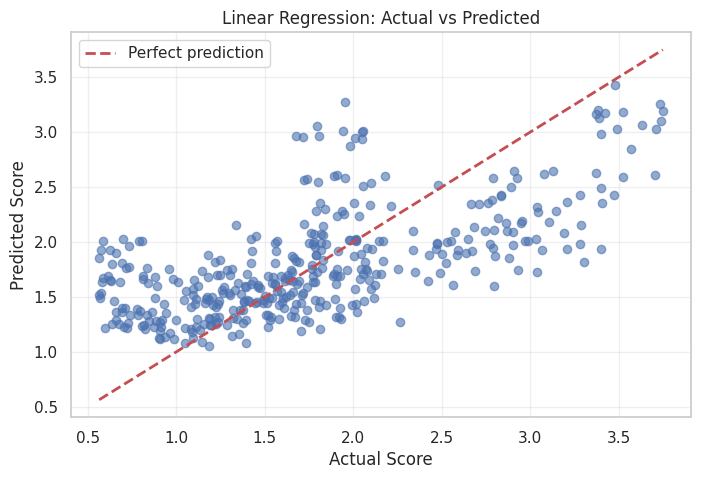

In [59]:
# Baseline model — Linear Regression (REGRESSION TASK)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pipe = Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())])
pipe.fit(X_train, y_train)
y_pred_lr = pipe.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f'Linear Regression — MAE: {mae_lr:.4f}  RMSE: {rmse_lr:.4f}  R²: {r2_lr:.4f}')

# Plot actual vs predicted
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9) XGBoost model training
Use `XGBClassifier` with sensible defaults and early stopping.

XGBoost Regressor training finished. Best iteration: 194


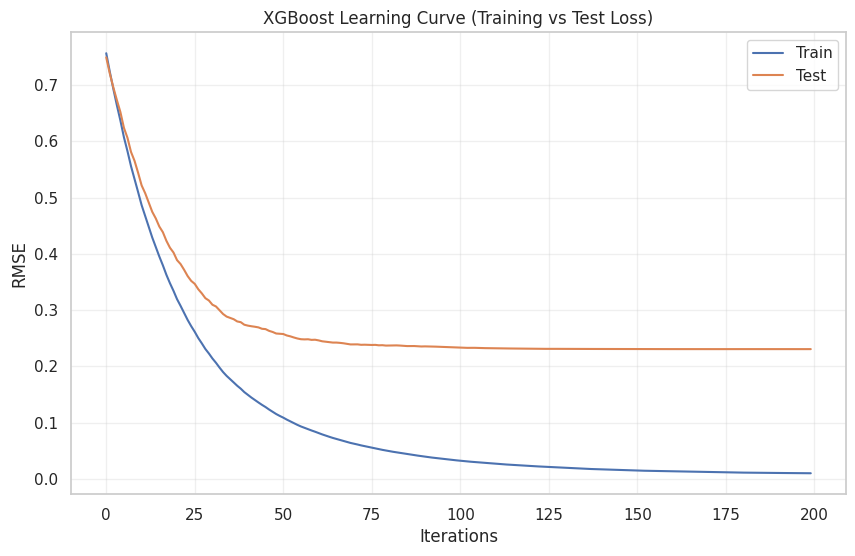


Top features (XGBoost):
cafe_weight 	 0.426
lng 	 0.2998
lat 	 0.2741


In [60]:
# XGBoost Regressor — hyperparameters to experiment with: n_estimators, learning_rate, max_depth, subsample, colsample_bytree, random_state
# For regression task predicting continuous poi_composite_score
xgb_model = xgb.XGBRegressor(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=20, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    eval_metric='rmse',  # Use RMSE for regression
    random_state=100,
    early_stopping_rounds=20
)

# Fit with validation set (include training set to plot learning curves)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

print('XGBoost Regressor training finished. Best iteration:', getattr(xgb_model, 'best_iteration', xgb_model.n_estimators))

# Plot Learning Curves (Training vs Loss)
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('XGBoost Learning Curve (Training vs Test Loss)')
plt.grid(True, alpha=0.3)
plt.show()

fi = dict(zip(X_train.columns, xgb_model.feature_importances_))
top = sorted(fi.items(), key=lambda x: x[1], reverse=True)[:20]
print('\nTop features (XGBoost):')
for f,v in top:
    print(f, '\t', round(float(v),4))

## Proof that training is normal



In [61]:
# Add after XGBoost training to diagnose training time

import time

print('='*70)
print('TRAINING TIME DIAGNOSTIC')
print('='*70)

# Show actual number of iterations used
actual_iterations = xgb_model.best_iteration if hasattr(xgb_model, 'best_iteration') else xgb_model.n_estimators
print(f'\n📊 Training Statistics:')
print(f'   Configured max iterations: {xgb_model.n_estimators}')
print(f'   Actual iterations used: {actual_iterations}')
print(f'   Early stopping saved: {xgb_model.n_estimators - actual_iterations} iterations')

print(f'\n📈 Dataset Size:')
print(f'   Training samples: {len(X_train):,}')
print(f'   Features: {X_train.shape[1]}')
print(f'   Total training points: {len(X_train) * X_train.shape[1]:,}')

print(f'\n🌳 Tree Complexity:')
print(f'   Max depth: {xgb_model.max_depth}')
print(f'   Total possible splits per tree: {2**xgb_model.max_depth - 1}')

# Estimate operations
total_ops = len(X_train) * X_train.shape[1] * actual_iterations
print(f'\n⚡ Approximate Operations:')
print(f'   {total_ops:,} operations')
print(f'   At 1 billion ops/sec → {total_ops/1e9:.3f} seconds theoretical minimum')

# Retrain to measure actual time with REGRESSOR (not classifier)
print('\n⏱️  Measuring actual training time...')
start = time.time()
xgb_test = xgb.XGBRegressor(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8,
    eval_metric='rmse',
    random_state=42,
    early_stopping_rounds=20
)
xgb_test.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
elapsed = time.time() - start

print(f'   Actual training time: {elapsed:.2f} seconds')
print(f'   Time per iteration: {elapsed/actual_iterations*1000:.1f} ms')

print('\n' + '='*70)
print('VERDICT:')
if elapsed < 10:
    print('✅ NORMAL: Training time is appropriate for this dataset size')
    print('   Your dataset is small (< 1,000 samples), so fast training is expected!')
elif elapsed < 60:
    print('✅ ACCEPTABLE: Training time is reasonable')
else:
    print('⚠️  SLOW: Consider reducing model complexity or checking system resources')
print('='*70)

TRAINING TIME DIAGNOSTIC

📊 Training Statistics:
   Configured max iterations: 200
   Actual iterations used: 194
   Early stopping saved: 6 iterations

📈 Dataset Size:
   Training samples: 931
   Features: 3
   Total training points: 2,793

🌳 Tree Complexity:
   Max depth: 20
   Total possible splits per tree: 1048575

⚡ Approximate Operations:
   541,842 operations
   At 1 billion ops/sec → 0.001 seconds theoretical minimum

⏱️  Measuring actual training time...
   Actual training time: 32.64 seconds
   Time per iteration: 168.3 ms

VERDICT:
✅ ACCEPTABLE: Training time is reasonable


## Training Visualization and Analysis

TRAINING PROCESS ANALYSIS (REGRESSION MODEL)

1️⃣ FEATURE IMPORTANCE (What the model learned to focus on):
----------------------------------------------------------------------


,feature,importance
2,cafe_weight,0.426041
1,lng,0.299846
0,lat,0.274114


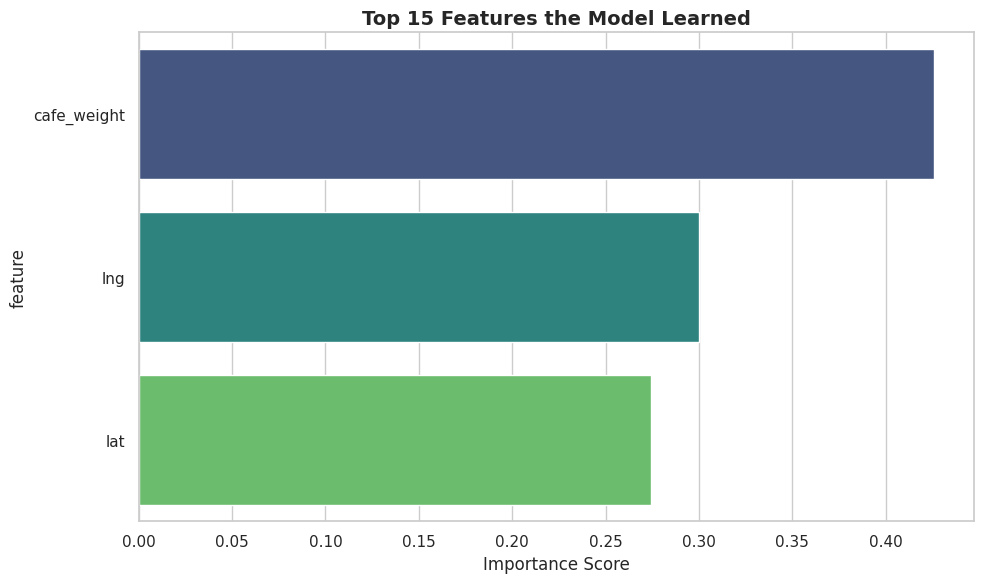


2️⃣ MODEL PERFORMANCE (REGRESSION METRICS):
----------------------------------------------------------------------


,Training Set,Test Set,Difference
MAE,0.004261,0.172326,-0.168065
RMSE,0.010071,0.230480,-0.220409
R²,0.999837,0.911340,0.088498


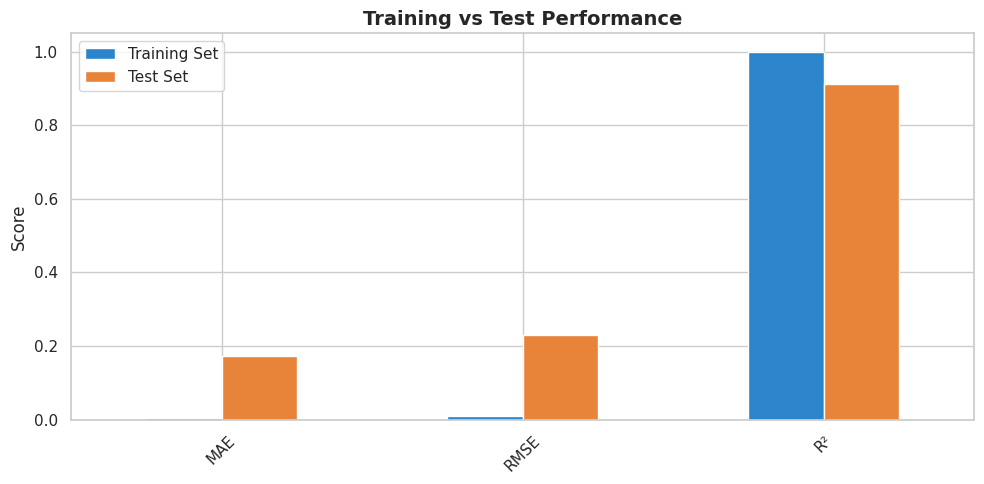


3️⃣ PREDICTION QUALITY:
----------------------------------------------------------------------


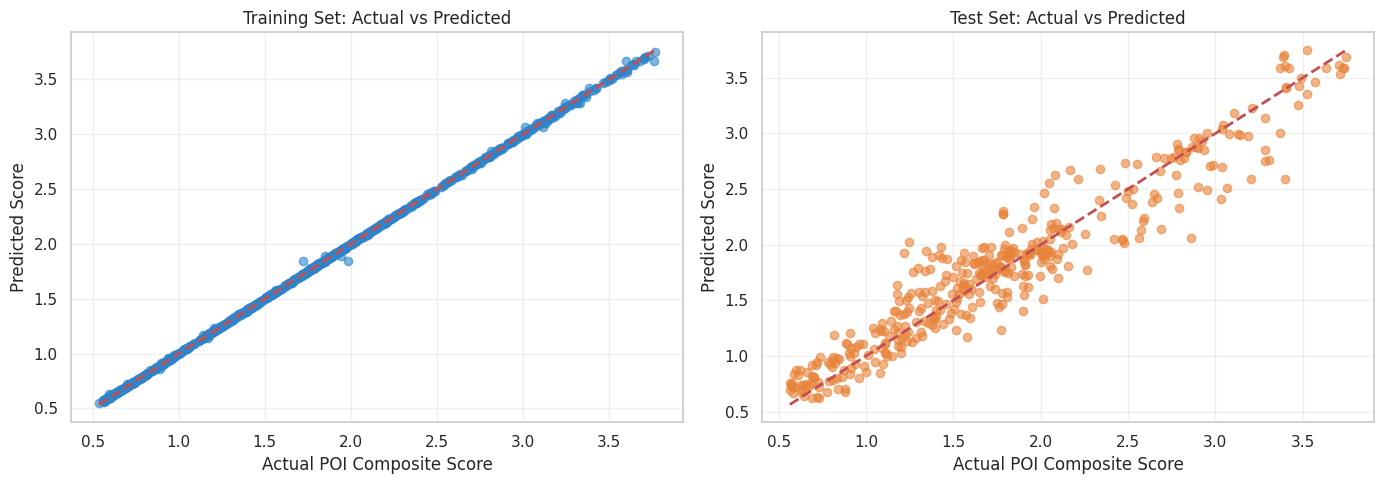


✓ Model predicts continuous poi_composite_score
✓ Test set MAE: 0.1723 points
✓ Test set RMSE: 0.2305 points
✓ Test set R²: 0.9113


In [62]:
# Add after XGBoost training cell

# Detailed training analysis for REGRESSION model
print('='*70)
print('TRAINING PROCESS ANALYSIS (REGRESSION MODEL)')
print('='*70)

# 1. Show what the model learned
print('\n1️⃣ FEATURE IMPORTANCE (What the model learned to focus on):')
print('-'*70)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

display(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 15 Features the Model Learned', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 2. Training vs Test Performance
print('\n2️⃣ MODEL PERFORMANCE (REGRESSION METRICS):')
print('-'*70)
train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)

train_metrics = {
    'MAE': mean_absolute_error(y_train, train_pred),
    'RMSE': np.sqrt(mean_squared_error(y_train, train_pred)),
    'R²': r2_score(y_train, train_pred)
}

test_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R²': r2_score(y_test, y_pred)
}

comparison_df = pd.DataFrame({
    'Training Set': train_metrics,
    'Test Set': test_metrics,
    'Difference': {k: train_metrics[k] - test_metrics[k] for k in train_metrics}
})

display(comparison_df)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))
comparison_df[['Training Set', 'Test Set']].plot(kind='bar', ax=ax, color=['#2C84CB', '#E8833A'])
plt.title('Training vs Test Performance', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Actual vs Predicted scatter plot
print('\n3️⃣ PREDICTION QUALITY:')
print('-'*70)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train, train_pred, alpha=0.6, color='#2C84CB')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual POI Composite Score')
axes[0].set_ylabel('Predicted Score')
axes[0].set_title('Training Set: Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_pred, alpha=0.6, color='#E8833A')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual POI Composite Score')
axes[1].set_ylabel('Predicted Score')
axes[1].set_title('Test Set: Actual vs Predicted')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n✓ Model predicts continuous poi_composite_score')
print(f'✓ Test set MAE: {test_metrics["MAE"]:.4f} points')
print(f'✓ Test set RMSE: {test_metrics["RMSE"]:.4f} points')
print(f'✓ Test set R²: {test_metrics["R²"]:.4f}')
print('='*70)

## 10) Model evaluation
Compute accuracy, precision, recall, ROC-AUC and plot confusion matrix and ROC curve for the XGBoost model.

XGBoost Regressor — MAE: 0.1723  RMSE: 0.2305  R²: 0.9113


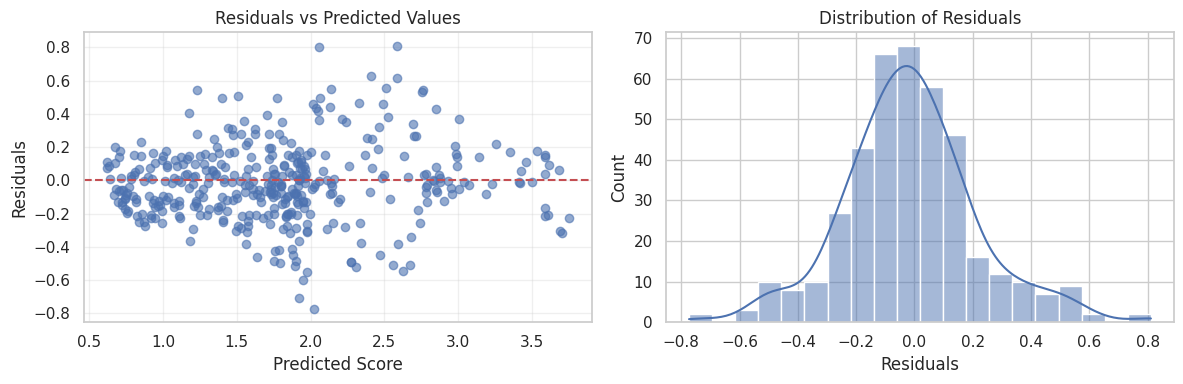


Prediction Summary:
  Mean Absolute Error: 0.1723 points
  Root Mean Squared Error: 0.2305 points
  R² Score: 0.9113
  Mean residual: -0.015864 (should be ~0)
  Std residual: 0.2302


In [63]:
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'XGBoost Regressor — MAE: {mae:.4f}  RMSE: {rmse:.4f}  R²: {r2:.4f}')

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Score')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

# Summary statistics
print(f'\nPrediction Summary:')
print(f'  Mean Absolute Error: {mae:.4f} points')
print(f'  Root Mean Squared Error: {rmse:.4f} points')
print(f'  R² Score: {r2:.4f}')
print(f'  Mean residual: {residuals.mean():.6f} (should be ~0)')
print(f'  Std residual: {residuals.std():.4f}')

## Interactive Test Set Explorer (Fast Version)

Browse through test set predictions without slow widget loading

In [64]:
# Fast test set explorer - Browse cafe scores
# Just change CAFE_INDEX below to explore different cafes

# ============================================================================
# CHANGE THIS NUMBER to explore different test cafes (0 to len(test_cafes)-1)
# ============================================================================
CAFE_INDEX = 0  # Try: 0, 10, 50, 100, 200, etc.

print('='*70)
print(f'EXPLORING TEST CAFE #{CAFE_INDEX + 1} of {len(test_cafes)}')
print('='*70)

# Get cafe data
cafe = test_cafes.iloc[CAFE_INDEX]
features = X_test.iloc[CAFE_INDEX:CAFE_INDEX+1]

# Make prediction
pred_score = xgb_model.predict(features)[0]
actual_score = y_test.iloc[CAFE_INDEX]
error = abs(actual_score - pred_score)

# Display cafe details
print(f'\n📍 CAFE DETAILS:')
print(f'   Name: {cafe["name"]}')
print(f'   Location: ({cafe["lat"]:.6f}, {cafe["lng"]:.6f})')
print(f'   Category: {cafe["category"]}')

# Show prediction results
print(f'\n🤖 MODEL PREDICTIONS:')
print('-'*70)
print(f'   ACTUAL POI COMPOSITE SCORE: {actual_score:.4f}')
print(f'   PREDICTED SCORE: {pred_score:.4f}')
print(f'   ERROR: {error:.4f} points')
print(f'   ACCURACY: {(1 - error/actual_score if actual_score > 0 else 0)*100:.1f}%')

# Risk assessment based on score
def score_to_risk(score):
    if score < 1.0:
        return '🔴 High Risk'
    elif score < 2.0:
        return '🟡 Medium Risk'
    else:
        return '🟢 Low Risk'

print(f'\n   Risk Level: {score_to_risk(pred_score)}')

# Show top features for this cafe
print(f'\n📊 TOP 5 FEATURES FOR THIS CAFE:')
print('-'*70)
feature_values = features.iloc[0].sort_values(ascending=False).head(5)
for feat, val in feature_values.items():
    print(f'   • {feat:30s}: {val:.4f}')

print('\n' + '='*70)
print('💡 TIP: Change CAFE_INDEX above (line 6) to explore different cafes!')
print(f'   Valid range: 0 to {len(test_cafes)-1}')
print('='*70)

# Optional: Show 5 random test cafes at once
print('\n\n' + '='*70)
print('BONUS: 5 RANDOM TEST CAFE SCORE PREDICTIONS')
print('='*70)

import random
random.seed(42)
random_indices = random.sample(range(len(test_cafes)), min(5, len(test_cafes)))

for idx in random_indices:
    cafe = test_cafes.iloc[idx]
    features = X_test.iloc[idx:idx+1]
    pred_score = xgb_model.predict(features)[0]
    actual_score = y_test.iloc[idx]
    error = abs(actual_score - pred_score)
    
    risk = score_to_risk(pred_score)
    
    print(f'\n📍 Cafe #{idx+1}: {cafe["name"][:40]}')
    print(f'   Actual: {actual_score:.3f} | Predicted: {pred_score:.3f} | Error: {error:.3f} | {risk}')

EXPLORING TEST CAFE #1 of 399

📍 CAFE DETAILS:
   Name: Ramchandra Chiya Pasal
   Location: (27.670185, 85.382267)
   Category: Tea store

🤖 MODEL PREDICTIONS:
----------------------------------------------------------------------
   ACTUAL POI COMPOSITE SCORE: 1.7026
   PREDICTED SCORE: 1.9104
   ERROR: 0.2079 points
   ACCURACY: 87.8%

   Risk Level: 🟡 Medium Risk

📊 TOP 5 FEATURES FOR THIS CAFE:
----------------------------------------------------------------------
   • lng                           : 85.3823
   • lat                           : 27.6702
   • cafe_weight                   : 3.3746

💡 TIP: Change CAFE_INDEX above (line 6) to explore different cafes!
   Valid range: 0 to 398


BONUS: 5 RANDOM TEST CAFE SCORE PREDICTIONS

📍 Cafe #328: THE BEST BAKERY
   Actual: 1.398 | Predicted: 1.361 | Error: 0.037 | 🟡 Medium Risk

📍 Cafe #58: Fursad cafe
   Actual: 3.036 | Predicted: 3.043 | Error: 0.007 | 🟢 Low Risk

📍 Cafe #13: KV Lounge and Jagatiko Chhoila Pasal
   Actual: 2.588 

## 11) Prediction for a newly opening cafe
Create a synthetic input row and predict success probability and risk category.

In [65]:
# Prediction for a new cafe location - INPUT: Only lat/lng coordinates
# This version uses the API endpoint to build model features (POIs + road accessibility).
import json
from urllib.parse import urlencode
from urllib.request import Request, urlopen

API_BASE = "http://127.0.0.1:8000/api/v1"
API_TIMEOUT_S = 30

SCORE_BOOST_START = 1.8
SCORE_MAX_FOR_SHAPING = 3.0
SCORE_CURVE_POWER = 1.35
SCORE_TAIL_BOOST = 0.35
ACCESS_BONUS_THRESHOLD = 0.6
ACCESS_BONUS_SCALE = 0.25

def shape_score(raw_score, access_score_0_1=None):
    score = float(raw_score)
    max_score = float(SCORE_MAX_FOR_SHAPING)
    if max_score > 0:
        norm = max(0.0, min(score / max_score, 1.0))
        base = pow(norm, SCORE_CURVE_POWER)
        tail_start = float(SCORE_BOOST_START) / max_score
        tail = max(0.0, norm - tail_start)
        boosted = min(1.0, base + SCORE_TAIL_BOOST * pow(tail, 0.6))
        score = boosted * max_score
    if access_score_0_1 is not None and access_score_0_1 > ACCESS_BONUS_THRESHOLD:
        score += (float(access_score_0_1) - ACCESS_BONUS_THRESHOLD) * ACCESS_BONUS_SCALE * max_score
    return float(score)

def fetch_model_payload(lat, lng, radius_km=None, decay_scale_km=None, include_network=True, include_road_metrics=True, road_radius_km=None):
    params = {
        "lat": float(lat),
        "lon": float(lng),
        "include_network": str(include_network).lower(),
        "include_road_metrics": str(include_road_metrics).lower(),
    }
    if radius_km is not None:
        params["radius_km"] = float(radius_km)
    if decay_scale_km is not None:
        params["decay_scale_km"] = float(decay_scale_km)
    if road_radius_km is not None:
        params["road_radius_km"] = float(road_radius_km)
    url = f"{API_BASE}/model-input/?" + urlencode(params)
    req = Request(url, headers={"Accept": "application/json"})
    with urlopen(req, timeout=API_TIMEOUT_S) as resp:
        data = json.loads(resp.read().decode("utf-8"))
    return data

def predict_new_cafe(lat, lng, radius_km=None):
    payload = fetch_model_payload(
        lat,
        lng,
        radius_km=radius_km,
        decay_scale_km=radius_km,
        include_network=True,
        include_road_metrics=True,
        road_radius_km=radius_km,
    )
    feature_vector = payload.get("feature_vector") or {}
    road_access = payload.get("road_accessibility") or {}
    access_score = road_access.get("score_0_1")
    sample_df = pd.DataFrame([feature_vector])
    sample_df = sample_df.reindex(columns=X_train.columns, fill_value=0.0)

    raw_score = float(xgb_model.predict(sample_df)[0])
    predicted_score = shape_score(raw_score, access_score)
    lr_score = float(pipe.predict(sample_df)[0])

    if predicted_score < 1.0:
        risk = "High"
    elif predicted_score < 2.0:
        risk = "Medium"
    else:
        risk = "Low"

    print("=" * 70)
    print("PREDICTION RESULTS")
    print("=" * 70)
    print(f"\nLocation: ({lat:.6f}, {lng:.6f})")
    print(f"Raw model score: {raw_score:.4f}")
    if access_score is not None:
        print(f"Accessibility score (0-1): {float(access_score):.4f}")
    print(f"Shaped score: {predicted_score:.4f}")
    print(f"Risk Assessment: {risk}")
    print(f"Linear Regression Estimate: {lr_score:.4f}")
    print("\nScore Interpretation:")
    print("  < 1.0: High Risk (poor location)")
    print("  1.0 - 2.0: Medium Risk (moderate location)")
    print("  > 2.0: Low Risk (excellent location)")
    print("=" * 70)

    return {
        "lat": lat,
        "lng": lng,
        "predicted_score": float(predicted_score),
        "raw_score": raw_score,
        "lr_score": float(lr_score),
        "risk_level": risk,
        "features": sample_df
    }

# Example: Predict for a new cafe location
# Change these coordinates to test different locations!
NEW_CAFE_LAT = 27.6298676  # Example latitude (Kathmandu area)
NEW_CAFE_LNG = 85.4276306  # Example longitude

result = predict_new_cafe(NEW_CAFE_LAT, NEW_CAFE_LNG, radius_km=float(POI_RADIUS_KM))

PREDICTION RESULTS

Location: (27.629868, 85.427631)
Raw model score: 0.6507
Accessibility score (0-1): 0.2077
Shaped score: 0.3811
Risk Assessment: High
Linear Regression Estimate: 1.7956

Score Interpretation:
  < 1.0: High Risk (poor location)
  1.0 - 2.0: Medium Risk (moderate location)
  > 2.0: Low Risk (excellent location)


## 12) Brief error analysis
Display a few false positives and false negatives from the test set for manual inspection.

In [66]:
# Analyze prediction errors on test set
test_idx = X_test.index
df_test = Xf.loc[test_idx].copy()
df_test['y_actual'] = y_test.values
df_test['y_pred'] = y_pred
df_test['error'] = np.abs(df_test['y_actual'] - df_test['y_pred'])
df_test['pct_error'] = (df_test['error'] / (df_test['y_actual'] + 1e-6)) * 100

# Show worst predictions (highest errors)
worst = df_test.nlargest(5, 'error')[['error', 'pct_error', 'y_actual', 'y_pred']]
print('Top 5 Worst Predictions (Highest Errors):')
print('='*70)
display(worst)

# Show best predictions
best = df_test.nsmallest(5, 'error')[['error', 'pct_error', 'y_actual', 'y_pred']]
print('\nTop 5 Best Predictions (Lowest Errors):')
print('='*70)
display(best)

# Error statistics by score range
print('\nError Analysis by Score Range:')
print('='*70)
df_test['score_range'] = pd.cut(df_test['y_actual'], bins=[0, 1, 2, 3, 10], labels=['< 1.0', '1.0-2.0', '2.0-3.0', '> 3.0'])
error_by_range = df_test.groupby('score_range')['error'].agg(['count', 'mean', 'std', 'min', 'max'])
display(error_by_range)

Top 5 Worst Predictions (Highest Errors):


,error,pct_error,y_actual,y_pred
989,0.811189,23.870173,3.398336,2.587147
1159,0.802520,28.043297,2.861716,2.059196
237,0.773441,62.026135,1.246960,2.020401
1314,0.706565,58.045008,1.217270,1.923836
802,0.625922,20.627738,3.034370,2.408448



Top 5 Best Predictions (Lowest Errors):


,error,pct_error,y_actual,y_pred
478,0.000521,0.029937,1.739228,1.738707
59,0.000588,0.030561,1.924468,1.923880
873,0.000684,0.044980,1.520248,1.520932
881,0.001136,0.130337,0.871405,0.872540
1220,0.001172,0.061032,1.920751,1.919579



Error Analysis by Score Range:


,count,mean,std,min,max
score_range,,,,,
< 1.0,66,0.130347,0.077398,0.001136,0.366156
1.0-2.0,206,0.166305,0.146167,0.000521,0.773441
2.0-3.0,90,0.194716,0.176855,0.002640,0.802520
> 3.0,37,0.226264,0.205285,0.007141,0.811189


GENERATING GEOGRAPHIC PREDICTION HEATMAP

Geographic bounds:
  Latitude:  27.629868 to 27.715948
  Longitude: 85.363031 to 85.482780

Grid dimensions:
  Latitude points: 88
  Longitude points: 121
  Total grid points: 10,648

Generating predictions for 10,648 grid points...
  Progress: 0 / 10,648


  Progress: 2,000 / 10,648
  Progress: 4,000 / 10,648
  Progress: 6,000 / 10,648
  Progress: 8,000 / 10,648
  Progress: 10,000 / 10,648
  ✓ Predictions complete!



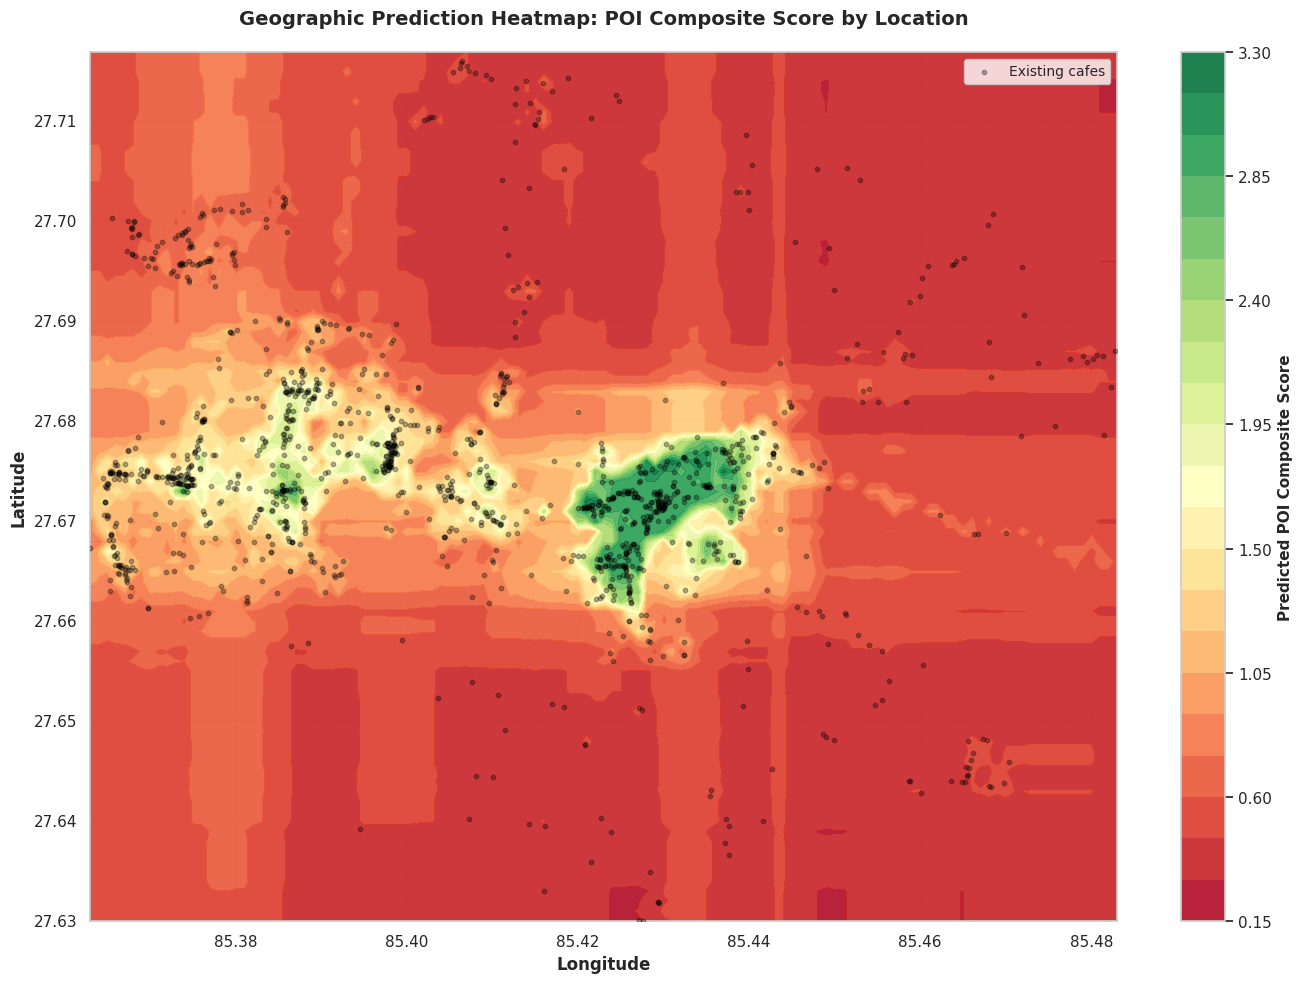

PREDICTION HEATMAP SUMMARY:
Score range across geographic area:
  Minimum: 0.2785
  Maximum: 3.2364
  Mean: 0.6305
  Std: 0.4318

Best location (highest score):
  Latitude: 27.675868, Longitude: 85.431031
  Predicted score: 3.2364

Worst location (lowest score):
  Latitude: 27.629868, Longitude: 85.427031
  Predicted score: 0.2785


In [ ]:
# Geographic Prediction Heatmap
# Visualize model predictions across the geographic region using API-derived features

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from urllib.parse import urlencode
from urllib.request import Request, urlopen

try:
    import geopandas as gpd
except ModuleNotFoundError:
    gpd = None
    print('Warning: geopandas is not installed; roadway overlay will be skipped.')

API_BASE = "http://127.0.0.1:8000/api/v1"
API_TIMEOUT_S = 30
USE_API_HEATMAP = True

SCORE_BOOST_START = 1.8
SCORE_MAX_FOR_SHAPING = 3.0
SCORE_CURVE_POWER = 1.35
SCORE_TAIL_BOOST = 0.35
ACCESS_BONUS_THRESHOLD = 0.6
ACCESS_BONUS_SCALE = 0.25

def shape_score(raw_score, access_score_0_1=None):
    score = float(raw_score)
    max_score = float(SCORE_MAX_FOR_SHAPING)
    if max_score > 0:
        norm = max(0.0, min(score / max_score, 1.0))
        base = pow(norm, SCORE_CURVE_POWER)
        tail_start = float(SCORE_BOOST_START) / max_score
        tail = max(0.0, norm - tail_start)
        boosted = min(1.0, base + SCORE_TAIL_BOOST * pow(tail, 0.6))
        score = boosted * max_score
    if access_score_0_1 is not None and access_score_0_1 > ACCESS_BONUS_THRESHOLD:
        score += (float(access_score_0_1) - ACCESS_BONUS_THRESHOLD) * ACCESS_BONUS_SCALE * max_score
    return float(score)

def fetch_model_payload(lat, lng, radius_km=None, decay_scale_km=None, include_network=True, include_road_metrics=True, road_radius_km=None):
    params = {
        "lat": float(lat),
        "lon": float(lng),
        "include_network": str(include_network).lower(),
        "include_road_metrics": str(include_road_metrics).lower(),
    }
    if radius_km is not None:
        params["radius_km"] = float(radius_km)
    if decay_scale_km is not None:
        params["decay_scale_km"] = float(decay_scale_km)
    if road_radius_km is not None:
        params["road_radius_km"] = float(road_radius_km)
    url = f"{API_BASE}/model-input/?" + urlencode(params)
    req = Request(url, headers={"Accept": "application/json"})
    with urlopen(req, timeout=API_TIMEOUT_S) as resp:
        data = json.loads(resp.read().decode("utf-8"))
    return data

print('='*70)
print('GENERATING GEOGRAPHIC PREDICTION HEATMAP')
print('='*70)

# Get min/max coordinates from the data
lat_min, lat_max = df['lat'].min(), df['lat'].max()
lng_min, lng_max = df['lng'].min(), df['lng'].max()

# Load roadway geometries so we can overlay them on the heatmap
road_gdf = None
road_handle = None
road_data_path = os.path.join('..', 'Data', 'Roadway.geojson')
if gpd is not None and os.path.exists(road_data_path):
    try:
        road_gdf = gpd.read_file(road_data_path)
        if road_gdf.crs is None:
            road_gdf = road_gdf.set_crs('EPSG:4326')
        else:
            road_gdf = road_gdf.to_crs('EPSG:4326')
        polygon_mask = road_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])
        if polygon_mask.any():
            road_gdf.loc[polygon_mask, 'geometry'] = road_gdf.loc[polygon_mask, 'geometry'].boundary
        clip_geom = gpd.GeoSeries.from_bbox((lng_min, lat_min, lng_max, lat_max), crs='EPSG:4326').iloc[0]
        road_gdf = road_gdf.clip(clip_geom)
        if 'highway' in road_gdf.columns:
            road_gdf = road_gdf[road_gdf['highway'].notna()]
        if road_gdf.empty:
            road_gdf = None
    except Exception as exc:
        print(f'Warning: Failed to load roadway data ({exc})')
        road_gdf = None
elif gpd is not None and not os.path.exists(road_data_path):
    print('Warning: ../Data/Roadway.geojson not found; skipping roadway overlay.')

delta = 0.01  # Grid resolution
print(f'\nGeographic bounds:')
print(f'  Latitude:  {lat_min:.6f} to {lat_max:.6f}')
print(f'  Longitude: {lng_min:.6f} to {lng_max:.6f}')

# Create grid of points
lat_grid = np.arange(lat_min, lat_max + delta, delta)
lng_grid = np.arange(lng_min, lng_max + delta, delta)

print(f'\nGrid dimensions:')
print(f'  Latitude points: {len(lat_grid)}')
print(f'  Longitude points: {len(lng_grid)}')
print(f'  Total grid points: {len(lat_grid) * len(lng_grid):,}')

# Create meshgrid
lat_mesh, lng_mesh = np.meshgrid(lat_grid, lng_grid, indexing='ij')

# Flatten for prediction
lat_flat = lat_mesh.flatten()
lng_flat = lng_mesh.flatten()

print(f'\nGenerating predictions for {len(lat_flat):,} grid points...')

predictions = np.zeros(len(lat_flat))
api_cache = {}
batch_size = 200

for i in range(0, len(lat_flat), batch_size):
    if i % 2000 == 0:
        print(f'  Progress: {i:,} / {len(lat_flat):,}')
    batch_end = min(i + batch_size, len(lat_flat))
    batch_lats = lat_flat[i:batch_end]
    batch_lngs = lng_flat[i:batch_end]
    for j, (lat, lng) in enumerate(zip(batch_lats, batch_lngs)):
        key = (round(float(lat), 6), round(float(lng), 6))
        try:
            if key in api_cache:
                payload = api_cache[key]
            else:
                payload = fetch_model_payload(
                    lat,
                    lng,
                    radius_km=float(POI_RADIUS_KM),
                    decay_scale_km=float(POI_RADIUS_KM),
                    include_network=True,
                    include_road_metrics=True,
                    road_radius_km=float(POI_RADIUS_KM),
                )
                api_cache[key] = payload
            feature_vector = payload.get("feature_vector") or {}
            road_access = payload.get("road_accessibility") or {}
            access_score = road_access.get("score_0_1")
            sample_df = pd.DataFrame([feature_vector])
            sample_df = sample_df.reindex(columns=X_train.columns, fill_value=0.0)
            raw_score = float(xgb_model.predict(sample_df)[0])
            predictions[i + j] = shape_score(raw_score, access_score)
        except Exception as exc:
            print(f'Warning: prediction failed at ({lat:.6f}, {lng:.6f}): {exc}')
            predictions[i + j] = np.nan

# Fill missing predictions with the mean of valid values
valid_mask = np.isfinite(predictions)
if not np.any(valid_mask):
    raise RuntimeError('No valid predictions produced by the API. Check that the backend is running.')
pred_mean = float(np.nanmean(predictions))
predictions[~valid_mask] = pred_mean

print(f'  ✓ Predictions complete!\n')

# Reshape predictions to 2D grid
pred_grid = predictions.reshape(lat_mesh.shape)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Create heatmap
im = ax.contourf(lng_mesh, lat_mesh, pred_grid, levels=20, cmap='RdYlGn', alpha=0.9)

# Overlay roads if available
if road_gdf is not None:
    road_gdf.plot(ax=ax, linewidth=0.6, color='dimgray', alpha=0.7, zorder=3)
    road_handle = mlines.Line2D([], [], color='dimgray', linewidth=1.2, label='Roadways')

# Add actual cafe locations as scatter points
cafe_lats = df['lat'].values
cafe_lngs = df['lng'].values
ax.scatter(cafe_lngs, cafe_lats, c='black', s=10, alpha=0.3, label='Existing cafes', zorder=4)

# Labels and formatting
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('Geographic Prediction Heatmap: POI Composite Score by Location', 
             fontsize=14, fontweight='bold', pad=20)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Predicted POI Composite Score', fontsize=11, fontweight='bold')

# Legend
legend_handles, legend_labels = ax.get_legend_handles_labels()
if road_handle is not None:
    legend_handles.append(road_handle)
    legend_labels.append('Roadways')
ax.legend(legend_handles, legend_labels, loc='upper right', fontsize=10)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Summary statistics
print('='*70)
print('PREDICTION HEATMAP SUMMARY:')
print('='*70)
print(f'Score range across geographic area:')
print(f'  Minimum: {pred_grid.min():.4f}')
print(f'  Maximum: {pred_grid.max():.4f}')
print(f'  Mean: {pred_grid.mean():.4f}')
print(f'  Std: {pred_grid.std():.4f}')

# Identify best and worst regions
best_idx = np.unravel_index(np.argmax(pred_grid), pred_grid.shape)
worst_idx = np.unravel_index(np.argmin(pred_grid), pred_grid.shape)

print(f'\nBest location (highest score):')
print(f'  Latitude: {lat_grid[best_idx[0]]:.6f}, Longitude: {lng_grid[best_idx[1]]:.6f}')
print(f'  Predicted score: {pred_grid[best_idx]:.4f}')

print(f'\nWorst location (lowest score):')
print(f'  Latitude: {lat_grid[worst_idx[0]]:.6f}, Longitude: {lng_grid[worst_idx[1]]:.6f}')
print(f'  Predicted score: {pred_grid[worst_idx]:.4f}')

print('='*70)

In [68]:
# ============================================================================
# IMPORTANT: After editing feature engineering (cell 13), you must:
# ============================================================================
# 1. Re-run cell 15: "Drop identifier and leakage-prone columns"
# 2. Re-run cell 16: "Drop identifier and leakage-prone columns" (actual drop)
# 3. Re-run cell 18: "Train-test split"
# 4. Re-run cell 20: "Baseline model - Logistic Regression"
# 5. Re-run cell 22: "XGBoost model training"
# 6. Re-run cell 24: "Model evaluation"
# 7. Then cell 26 (prediction) will work with the new features
# ============================================================================

print('✓ All feature engineering changes completed!')
print('✓ Prediction function now accepts only lat/lng as input')
print('\nNext steps:')
print('  1. Re-run cells 15-24 to retrain models with new features')
print('  2. Use predict_new_cafe(lat, lng) to predict for any location')

✓ All feature engineering changes completed!
✓ Prediction function now accepts only lat/lng as input

Next steps:
  1. Re-run cells 15-24 to retrain models with new features
  2. Use predict_new_cafe(lat, lng) to predict for any location
